# Import Tiny Yolo from ONNX with DLPy

In this example, we will import an ONNX Tiny YOLO V2 Model using DLPy.  
This model can be downloaded from the SAS Deep Learning Models page: http://support.sas.com/documentation/prod-p/vdmml/zip/index.html

Import Packages

In [1]:
import dlpy
from dlpy import ImageTable, Model
from dlpy.model import Gpu, DataSpec
from dlpy.layers import *
from dlpy.utils import *
import onnx
from swat import *

Connect to CAS

In [2]:
s = swat.CAS(cashost, casport)

### Load ONNX model

In [3]:
onnx_model = onnx.load('/data/tmp/tiny_yolov2_313cls/Tiny-Yolov2.onnx')

### Create DLPy detection layer object

In [4]:
yolo_anchors = [9.778984, 5.595484, 2.98513, 3.924927, 11.580547, 11.534526, 5.183913, 8.863515, 1.09074, 1.433951]

output_layer = Detection(name='Detection1',
                         detection_model_type='yolov2', 
                         anchors=yolo_anchors, 
                         predictions_per_grid=5, 
                         class_number=313,
                         softmax_for_class_prob=True,
                         object_scale=5.0,
                         prediction_not_a_object_scale=1.0,
                         class_scale=1.0,
                         coord_scale=1.0,
                         act='LOGISTIC',
                         grid_number=13,
                         coord_type='YOLO',
                         detection_threshold=0.3,
                         iou_threshold=0.3)

### Import ONNX model and generate SAS compatible H5 weights

In [5]:
# set scale to 1/255
model1 = Model.from_onnx_model(conn=s, 
                               onnx_model=onnx_model,
                               output_model_table=dict(caslib='CASUSER',name='tiny_yolov2_313cls'),
                               scale=1/255., 
                               output_layer=output_layer)

NOTE: Successfully written weights file as /data/alex_data/tmp/tiny_yolov2_313cls_weights.onnxmodel.h5
NOTE: Model table is attached successfully!
NOTE: Model is named to "tiny_yolov2_313cls" according to the model name in the table.
NOTE: Successfully imported ONNX model.


In [6]:
model1.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters
0,0,input1,input,,,None,"(416, 416, 3)","(0, 0)"
1,1,conv_0,convo,"(3, 3)","(1.0, 1.0)",Identity,"(416, 416, 16)","(432, 0)"
2,2,batchnormalization_1,batchnorm,,,Leaky,"(416, 416, 16)","(0, 32)"
3,3,maxpool_3,pool,"(2, 2)","(2.0, 2.0)",Max,"(208, 208, 16)","(0, 0)"
4,4,conv_4,convo,"(3, 3)","(1.0, 1.0)",Identity,"(208, 208, 32)","(4608, 0)"
5,5,batchnormalization_5,batchnorm,,,Leaky,"(208, 208, 32)","(0, 64)"
6,6,maxpool_7,pool,"(2, 2)","(2.0, 2.0)",Max,"(104, 104, 32)","(0, 0)"
7,7,conv_8,convo,"(3, 3)","(1.0, 1.0)",Identity,"(104, 104, 64)","(18432, 0)"
8,8,batchnormalization_9,batchnorm,,,Leaky,"(104, 104, 64)","(0, 128)"
9,9,maxpool_11,pool,"(2, 2)","(2.0, 2.0)",Max,"(52, 52, 64)","(0, 0)"


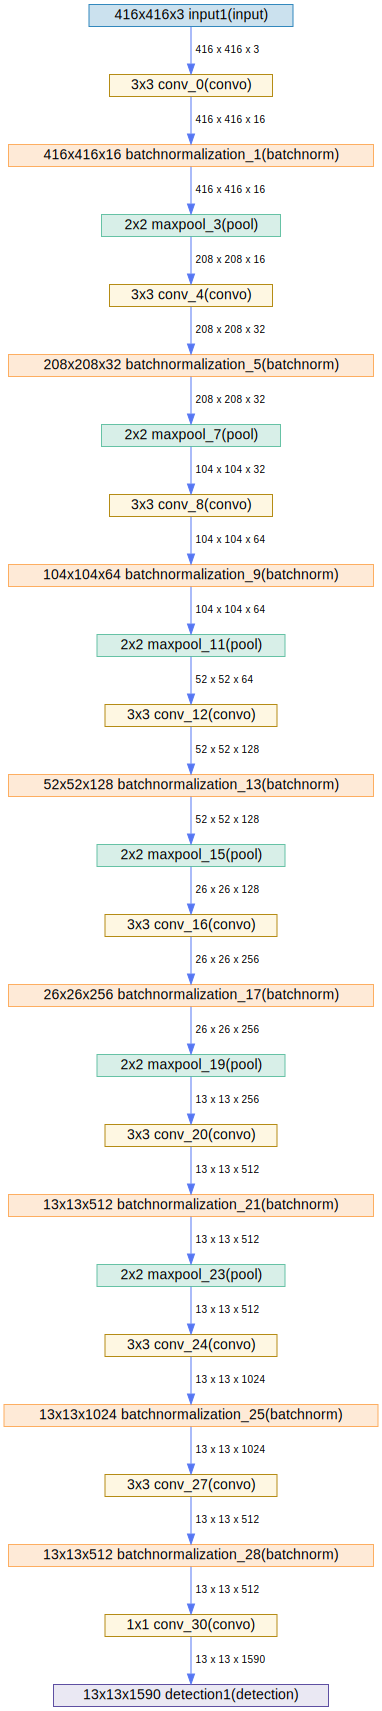

In [7]:
model1.plot_network()

### Dataspec definitions

In [8]:
# target variables
maxObjs = 5
targets = ['_nObjects_']
for i in range(maxObjs):
    targets.append('_Object{}_'.format(i))
    for sp in ["x", "y", "width", "height"]:
        targets.append('_Object{}_{}'.format(i, sp))
    
# input variables
inputVars = ['_image_']

# data specs
data_spec = []
data_spec.append(DataSpec(type_='IMAGE', 
                          layer='input1', 
                          data=inputVars))
data_spec.append(DataSpec(type_='OBJECTDETECTION', 
                          layer='detection1', 
                          data=targets, 
                          nominals=['_Object{}_'.format(i) for i in range(maxObjs)]))

### Load H5 file

labels.csv specifies the class names, for example:  

label_id, label  
0, "object0",  
1, "object1",  
2, "object2",  
3, "object3",  
4, "object4",  
5, "object5"  

In [9]:
model1.load_weights(path='/data/tmp/tiny_yolov2_313cls_weights.onnxmodel.h5',
                    labels=True,
                    data_spec=data_spec,
                    label_file_name='/data/tmp/tiny_yolov2_313cls_labels.csv', label_length=20)

NOTE: Cloud Analytic Services made the uploaded file available as table NEW_LABEL_TABLE_YJCKVO in caslib CASUSER(sasdemo).
NOTE: The table NEW_LABEL_TABLE_YJCKVO has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.
NOTE: Model weights attached successfully!


## Load test images

In [10]:
img = ImageTable.load_files(s, path='/data/tmp/testimages/')

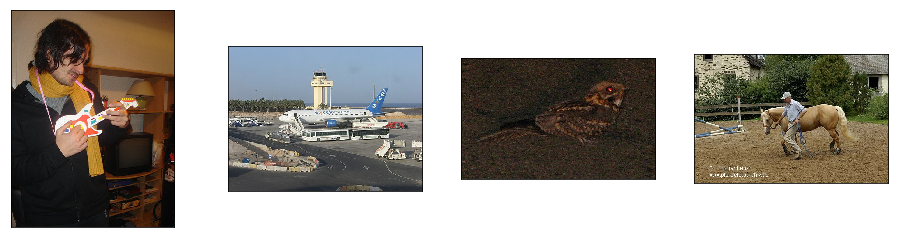

In [11]:
img.show(randomize=True, nimages=4)

In [12]:
img.image_summary

jpg                  4952
minWidth              148
maxWidth              500
minHeight             139
maxHeight             500
meanWidth         471.247
meanHeight        381.538
mean1stChannel    99.8842
min1stChannel           0
max1stChannel         255
mean2ndChannel    108.463
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    114.346
min3rdChannel           0
max3rdChannel         255
dtype: object

Resize to 416x416

In [13]:
img.resize(416)

Score with GPU

In [14]:
model1.predict(img, gpu = Gpu(devices=[0]))

NOTE: Using H08s017Rb318nc0.net.sas.com: 1 out of 4 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          4952
 1  Number of Observations Used             0
 2     Average IOU in Detection             .

[OutputCasTables]

              casLib              Name  Rows  Columns  \
 0  CASUSER(sasdemo)  Valid_Res_uT1zo0  4952     5075   
 
                                             casTable  
 0  CASTable('Valid_Res_uT1zo0', caslib='CASUSER(s...  

+ Elapsed: 11.3s, user: 69.2s, sys: 6.1s, mem: 1.7e+03mb

### Display Scoring Results

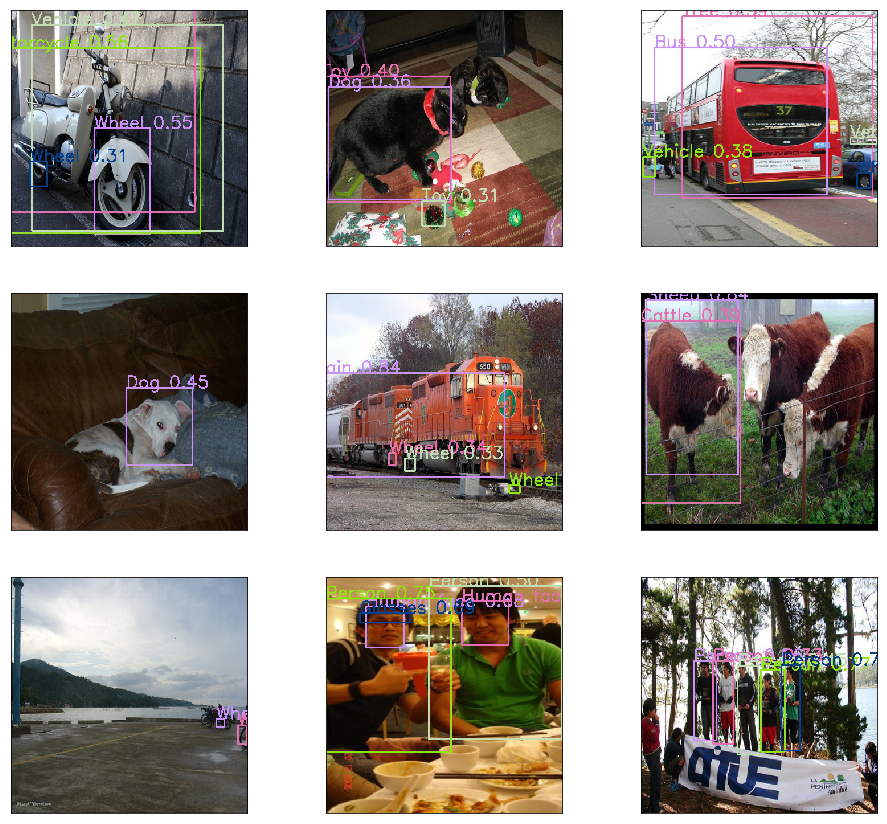

In [15]:
display_object_detections(conn=s, 
                          coord_type='yolo', 
                          max_objects=5, 
                          table=model1.valid_res_tbl, 
                          num_plot=10,
                          n_col=3)

## Model Deployment

Deployment options:  

1. ASTORE  
2. ONNX  
3. Model weights  

In [16]:
# deploy ASTORE file
model1.deploy('/disk/linux/yolo')

NOTE: Model astore file saved successfully.


In [17]:
s.endsession()

+ Elapsed: 0.000128s, sys: 0.000124s, mem: 0.194mb